In [1]:

import random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
from torch.autograd import Variable
torch.manual_seed(180457)

In [10]:
batchsize = 100
imagesize = 28
lr = 1e-3
hidden_size = 40
outf = "./MNIST_VAE_SAMPLES/"

In [3]:
dataset = dset.MNIST(root = './MNIST/',
                     transform=transforms.Compose([
                           transforms.ToTensor(),
                       ]),
                      download = True)


loader = torch.utils.data.DataLoader(dataset = dataset,
                                     batch_size = batchsize,
                                     shuffle = True)


In [4]:
class VAE(nn.Module):
    def __init__(self,hidden_size = 40):
        super(VAE,self).__init__()
    
        n = 64
        
        self.conv1 = nn.Sequential(nn.Conv2d(1,n,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(n),
                                 nn.LeakyReLU(0.2,inplace=True))

        self.conv2 = nn.Sequential(nn.Conv2d(n,2*n,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(2*n),
                                 nn.LeakyReLU(0.2,inplace=True))
        
        self.conv3 = nn.Sequential(nn.Conv2d(2*n,4*n,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(n*4),
                                 nn.LeakyReLU(0.2,inplace=True))
        
        self.conv4 = nn.Sequential(nn.Conv2d(n*4,n*2,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(n*2),
                                 nn.LeakyReLU(0.2,inplace=True))
        
        self.conv5 = nn.Sequential(nn.Conv2d(n*2,n,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(n),
                                 nn.LeakyReLU(0.2,inplace=True))

        self.fc11 = nn.Linear(n * 7 * 7, hidden_size)
        self.fc12 = nn.Linear(n * 7 * 7, hidden_size)
        self.fc2 = nn.Linear(hidden_size, n * 7 * 7)

        self.deconv1 = nn.Sequential(nn.ConvTranspose2d(n,2*n,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(n*2),
                                 nn.ReLU())
        
        self.deconv2 = nn.Sequential(nn.ConvTranspose2d(2*n,4*n,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(4*n),
                                 nn.ReLU())
        
        self.deconv3 = nn.Sequential(nn.ConvTranspose2d(4*n,2*n,kernel_size=4,stride=2,padding=1),
                                 nn.BatchNorm2d(n*2),
                                 nn.ReLU())
        
        self.deconv4 = nn.Sequential(nn.ConvTranspose2d(2*n,n,kernel_size=3,stride=1,padding=1),
                                 nn.BatchNorm2d(n),
                                 nn.ReLU())
        
        self.deconv5 = nn.Sequential(nn.ConvTranspose2d(n,1,kernel_size=4,stride=2,padding=1),
                                 nn.Sigmoid())


    def encoder(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.conv5(out)
#         print(out.size)
        return self.fc11(out.view(out.size(0),-1)),self.fc12(out.view(out.size(0),-1))

    def sampler(self, mu, logvar):
        var = logvar.mul(0.5).exp_()
        eps = torch.FloatTensor(var.size()).normal_()
        eps = Variable(eps)
        if(use_cuda):
            eps = eps.cuda()
        return eps.mul(var).add_(mu)

    def decoder(self, x):
        out = self.fc2(x)
        out = self.deconv1(out.view(x.size(0), 64, 7, 7))
        # opt.batchSize x n x 7 x 7
        out = self.deconv2(out)
        out = self.deconv3(out)
        out = self.deconv4(out)
        out = self.deconv5(out)
        return out
    
    def forward(self, x):
        mu, logvar = self.encoder(x)
        out = self.sampler(mu, logvar)
        out = self.decoder(out)
        return out, mu, logvar


In [35]:
if torch.cuda.is_available:
    use_cuda = True
else:
    false

In [36]:
use_cuda

True

In [48]:
model = VAE()
if(use_cuda):
    model.cuda()
bce = nn.BCELoss()
bce.size_average = False
if(use_cuda):
    bce.cuda()
optimizer = optim.Adam(model.parameters(),lr=lr)


In [49]:

# Loss function
def criterion(x_out,x_in,z_mu,z_logvar):
    bce_loss = F.binary_cross_entropy(x_out,x_in,size_average=False)
    kld_loss = -0.5 * torch.sum(1 + z_logvar - (z_mu ** 2) - torch.exp(z_logvar))
    loss = (bce_loss + kld_loss) / x_out.size(0) # normalize by batch size
    return loss

In [50]:
# Training
def train(model,optimizer,dataloader,num_epochs):
    losses = []
    model.train()
    epoch_losses = []
    for epoch in range(num_epochs):
        epoch_loss = []
        for i,(images,_) in enumerate(dataloader):
            
            x = Variable(images)
            model.zero_grad()
            x = x.cuda()
            x_out, z_mu, z_logvar = model.forward(x)
            loss = criterion(x_out,x,z_mu,z_logvar)
            loss.backward()
            optimizer.step()
#             print(loss)
            losses.append(format(loss))
            epoch_loss.append(format(loss))
#             losses.append(tensor.item(loss.data[0]))
            
            if i % 100 == 0 : 
                print("loss = {} epoch = {} minibatch = {}/600".format(sum([float(x) for x in epoch_loss])/(i+1),epoch,i))
#                 losses.append(format(loss))
#                 print(losses)
#         print(epoch_losses)
        epoch_losses.append(sum([float(x) for x in epoch_loss])/600)
        print("Epoch {} completed . Epoch loss = {}".format(epoch+1,sum([float(x) for x in epoch_loss])/(600)))
    return losses,epoch_losses


In [51]:
num_epochs = 30
train_losses,epoch_losses = train(model,optimizer,loader,num_epochs)

loss = 756.9663696289062 epoch = 0 minibatch = 0/600
loss = 231.79705750116028 epoch = 0 minibatch = 100/600
loss = 181.04797340506937 epoch = 0 minibatch = 200/600
loss = 159.47064604394856 epoch = 0 minibatch = 300/600
loss = 147.32187254946132 epoch = 0 minibatch = 400/600
loss = 139.5529469777486 epoch = 0 minibatch = 500/600
Epoch 1 completed . Epoch loss = 134.26281628926594
loss = 103.88211059570312 epoch = 1 minibatch = 0/600
loss = 105.68598854895866 epoch = 1 minibatch = 100/600
loss = 105.57782187390683 epoch = 1 minibatch = 200/600
loss = 105.29461307462267 epoch = 1 minibatch = 300/600
loss = 105.13480219282117 epoch = 1 minibatch = 400/600
loss = 104.90877111134176 epoch = 1 minibatch = 500/600
Epoch 2 completed . Epoch loss = 104.65971422831217
loss = 100.53170013427734 epoch = 2 minibatch = 0/600
loss = 102.6644695772983 epoch = 2 minibatch = 100/600
loss = 102.68854906072664 epoch = 2 minibatch = 200/600
loss = 102.77900987289277 epoch = 2 minibatch = 300/600
loss = 10

loss = 93.7852347998128 epoch = 21 minibatch = 300/600
loss = 93.82346730220348 epoch = 21 minibatch = 400/600
loss = 93.85286808584978 epoch = 21 minibatch = 500/600
Epoch 22 completed . Epoch loss = 93.89992622375489
loss = 92.40451049804688 epoch = 22 minibatch = 0/600
loss = 94.16261419919458 epoch = 22 minibatch = 100/600
loss = 94.00946701581205 epoch = 22 minibatch = 200/600
loss = 93.95909825828781 epoch = 22 minibatch = 300/600
loss = 93.81198371259352 epoch = 22 minibatch = 400/600
loss = 93.76235278161938 epoch = 22 minibatch = 500/600
Epoch 23 completed . Epoch loss = 93.74797873179118
loss = 94.84123992919922 epoch = 23 minibatch = 0/600
loss = 93.56789232008528 epoch = 23 minibatch = 100/600
loss = 93.57927088950997 epoch = 23 minibatch = 200/600
loss = 93.54786395709776 epoch = 23 minibatch = 300/600
loss = 93.52143355676361 epoch = 23 minibatch = 400/600
loss = 93.58531968655463 epoch = 23 minibatch = 500/600
Epoch 24 completed . Epoch loss = 93.5598407236735
loss = 93.

In [61]:
x = []
for i in range(30):
    x.append(i)
x = np.array(x)
train_losses = np.array(train_losses)
epoch_losses = np.array(epoch_losses)

In [72]:
epoch_losses = epoch_losses.reshape(30)
x = x.reshape(30)

In [73]:
x

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29])

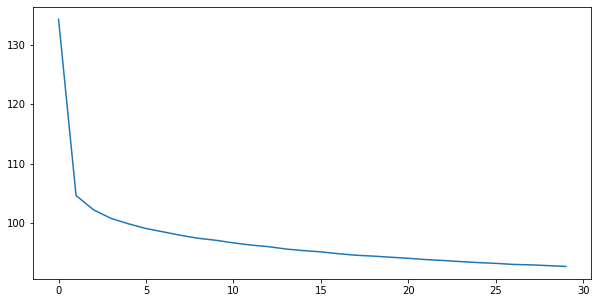

In [74]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,5))
plt.plot(x,epoch_losses)
plt.show()

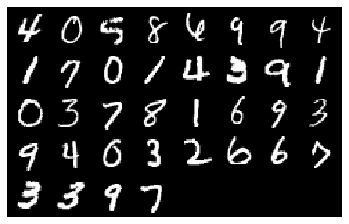

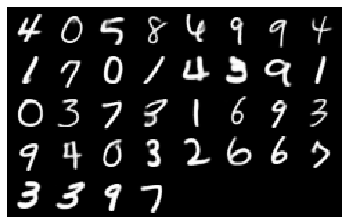

In [110]:
# Visualize VAE input and reconstruction
from torchvision.utils import make_grid as make_image_grid
def visualize_mnist_vae(model,dataloader,num=36):
    def imshow(img):
        npimg = img.numpy()
        plt.imshow(np.transpose(npimg,(1,2,0)))
        plt.axis('off')
        plt.show()
        
    images,_ = iter(dataloader).next()
    images = images[0:num,:,:]
    x_in = Variable(images)
    x_in = x_in.cuda()
    x_out,_,_ = model(x_in)
    x_out = x_out.data
    x_out = torch.Tensor.cpu(x_out)
#     print(type(x_out))
    imshow(make_image_grid(images))
    imshow(make_image_grid(x_out))

visualize_mnist_vae(model,loader)

In [106]:
# Train, test and visualize reconstruction using a 2D latent space
model2 = VAE(hidden_size=2)
model2.cuda()
optimizer2 = torch.optim.Adam(model2.parameters(),lr=lr)

train2_losses ,epoch2_losses= train(model2,optimizer2,loader,num_epochs = 30)


loss = 559.8179321289062 epoch = 0 minibatch = 0/600
loss = 215.73364892336403 epoch = 0 minibatch = 100/600
loss = 192.52822299027324 epoch = 0 minibatch = 200/600
loss = 183.42966169693145 epoch = 0 minibatch = 300/600
loss = 177.9642511686482 epoch = 0 minibatch = 400/600
loss = 174.24960491614428 epoch = 0 minibatch = 500/600
Epoch 1 completed . Epoch loss = 171.67013748168947
loss = 154.26870727539062 epoch = 1 minibatch = 0/600
loss = 157.12467322019066 epoch = 1 minibatch = 100/600
loss = 156.14889708561682 epoch = 1 minibatch = 200/600
loss = 155.77770950469463 epoch = 1 minibatch = 300/600
loss = 155.57264823628185 epoch = 1 minibatch = 400/600
loss = 155.19316761983845 epoch = 1 minibatch = 500/600
Epoch 2 completed . Epoch loss = 154.96736157735188
loss = 148.3431396484375 epoch = 2 minibatch = 0/600
loss = 152.0195265666093 epoch = 2 minibatch = 100/600
loss = 152.02816446029132 epoch = 2 minibatch = 200/600
loss = 151.72282394459873 epoch = 2 minibatch = 300/600
loss = 151

loss = 139.81422477456468 epoch = 21 minibatch = 200/600
loss = 139.85010460128024 epoch = 21 minibatch = 300/600
loss = 140.16218639193033 epoch = 21 minibatch = 400/600
loss = 140.11523950694803 epoch = 21 minibatch = 500/600
Epoch 22 completed . Epoch loss = 140.01596792856853
loss = 137.23733520507812 epoch = 22 minibatch = 0/600
loss = 140.63406477824296 epoch = 22 minibatch = 100/600
loss = 139.8465124481353 epoch = 22 minibatch = 200/600
loss = 140.05857509473628 epoch = 22 minibatch = 300/600
loss = 140.14331456134445 epoch = 22 minibatch = 400/600
loss = 139.9801713102116 epoch = 22 minibatch = 500/600
Epoch 23 completed . Epoch loss = 139.74331043243407
loss = 145.0609588623047 epoch = 23 minibatch = 0/600
loss = 140.11126036691195 epoch = 23 minibatch = 100/600
loss = 139.8015485545296 epoch = 23 minibatch = 200/600
loss = 139.64700913033215 epoch = 23 minibatch = 300/600
loss = 139.61997751821008 epoch = 23 minibatch = 400/600
loss = 139.44812502071053 epoch = 23 minibatch 

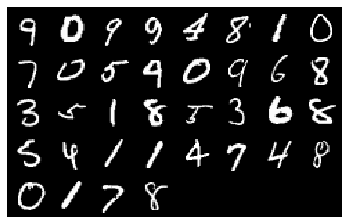

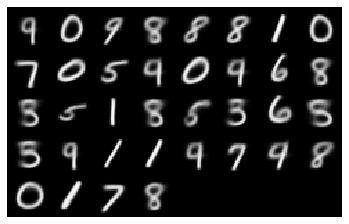

In [111]:
visualize_mnist_vae(model2,loader)

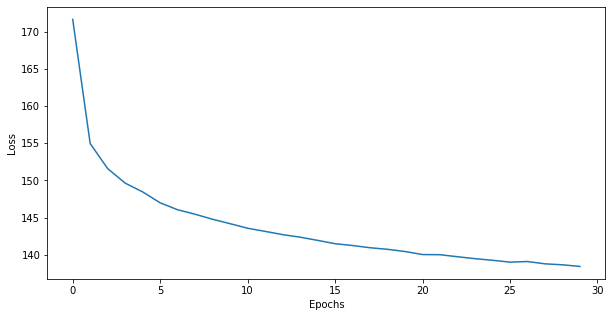

In [109]:
x = []
for i in range(30):
    x.append(i)
x = np.array(x)
train2_losses = np.array(train2_losses)
epoch2_losses = np.array(epoch2_losses)
plt.figure(figsize=(10,5))
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.plot(x,epoch2_losses)
plt.show()

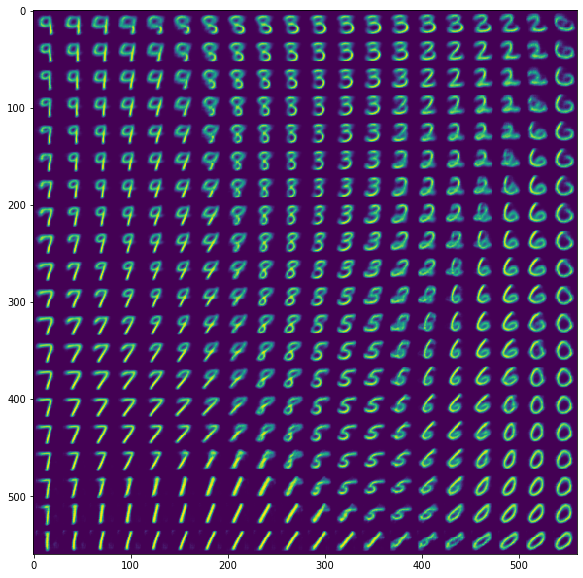

In [99]:
# Visualize digits generated from latent space grid
from scipy.stats import norm
def generate_from_decoder(model,num=20,range_type='g'):
    image_grid = np.zeros([num*28,num*28])

    if range_type == 'l': # linear range
        # corresponds to output range of visualize_encoding()
        range_space = np.linspace(-4,4,num)
    elif range_type == 'g': # gaussian range
        range_space = norm.ppf(np.linspace(0.01,0.99,num))

    for i, x in enumerate(range_space):
        for j, y in enumerate(reversed(range_space)):
            z = torch.FloatTensor([[x,y]])
            z = z.cuda()
            image = model.decoder(z)
#             print(image)
#             break
            image = image.cpu()
            image = image.detach().numpy()
            image_grid[(j*28):((j+1)*28),(i*28):((i+1)*28)] = image

    plt.figure(figsize=(10, 10))
    plt.imshow(image_grid)
    plt.show()
    
#using gaussian range of 
generate_from_decoder(model2)

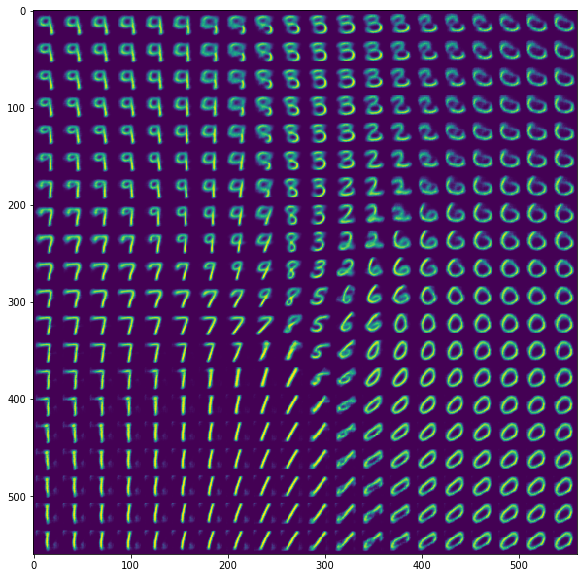

In [100]:
#using linear range of encodinng vectors
generate_from_decoder(model2,num=20,range_type='l')